In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import GridSearchCV, train_test_split
from scikeras.wrappers import KerasClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.inspection import permutation_importance # for MDA analysis

In [2]:
df = pd.read_csv('main_df.csv', index_col=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114883 entries, 0 to 119142
Data columns (total 16 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   customer_zip_code_prefix    114883 non-null  int64  
 1   order_item_id               114883 non-null  float64
 2   price                       114883 non-null  float64
 3   freight_value               114883 non-null  float64
 4   payment_value               114883 non-null  float64
 5   product_name_lenght         114883 non-null  float64
 6   product_description_lenght  114883 non-null  float64
 7   product_weight_g            114883 non-null  float64
 8   product_length_cm           114883 non-null  float64
 9   product_height_cm           114883 non-null  float64
 10  product_width_cm            114883 non-null  float64
 11  seller_zip_code_prefix      114883 non-null  float64
 12  review_score                114883 non-null  float64
 13  convert_status

In [14]:
df1 = df.drop('convert_status', axis=1)

vif = pd.DataFrame()
vif["features"] = df1.columns
vif["VIF Factor"] = [variance_inflation_factor(df1.values, i) for i in range(df1.shape[1])]
vif

,features,VIF Factor
0,customer_zip_code_prefix,2.565196
1,order_item_id,4.641961
2,price,3.944999
3,freight_value,5.072135
4,payment_value,3.990174
5,product_name_lenght,14.360749
6,product_description_lenght,2.618465
7,product_weight_g,3.306116
8,product_length_cm,6.754844
9,product_height_cm,3.761738


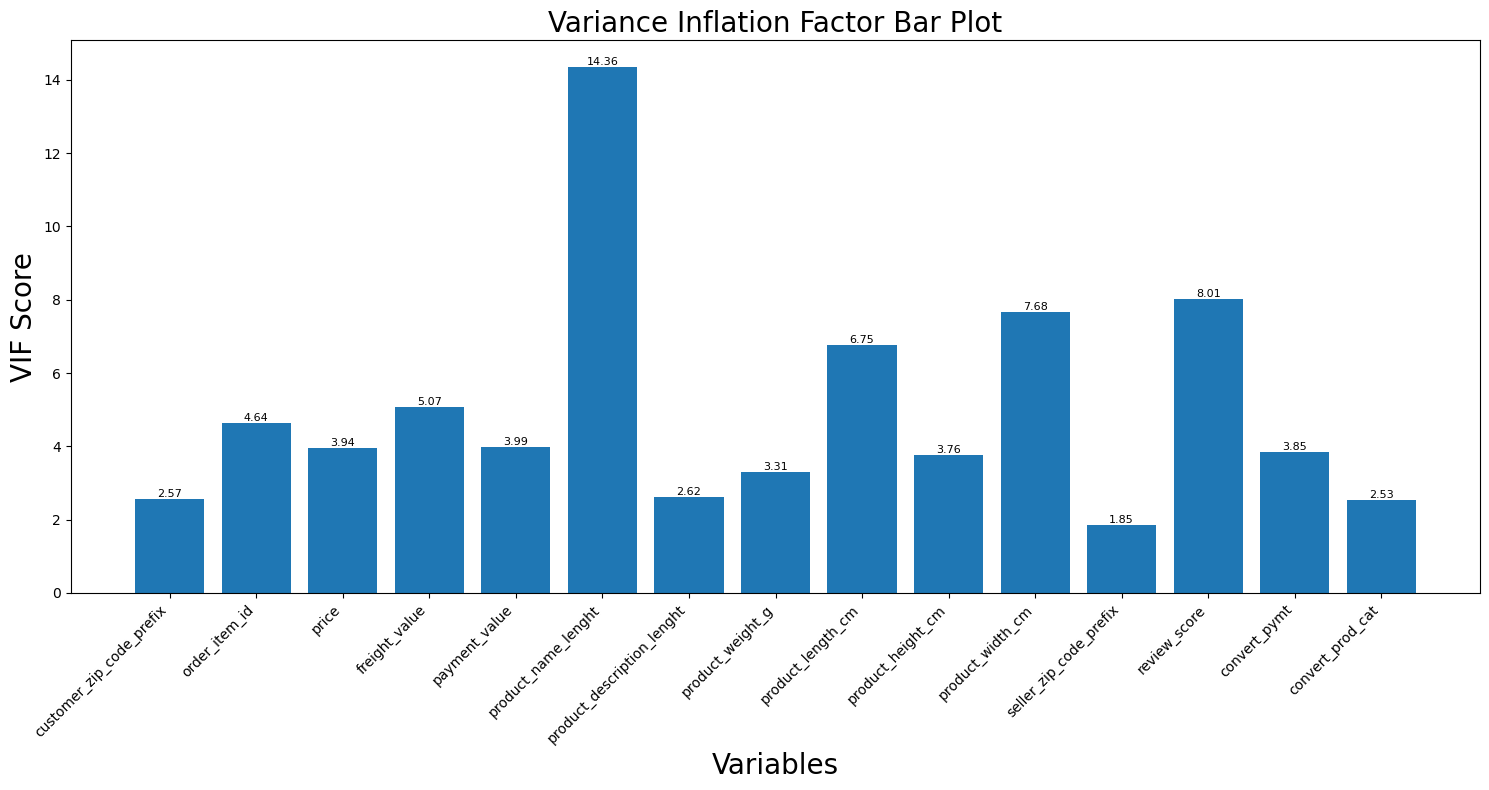

In [8]:
plt.figure(figsize=(15, 8))
bars = plt.bar(vif['features'], vif['VIF Factor'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('VIF Score', fontsize=20)
plt.xlabel('Variables', fontsize=20)
plt.title('Variance Inflation Factor Bar Plot', fontsize=20)
plt.tight_layout()

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), 
             va='bottom',
             ha='center',
             fontsize=8)

plt.show()

In [17]:
corr_matrix = df1.corr()
corr_matrix

,customer_zip_code_prefix,order_item_id,price,freight_value,payment_value,product_name_lenght,product_description_lenght,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,review_score,convert_pymt,convert_prod_cat
customer_zip_code_prefix,1.000000,-0.003199,0.043020,0.226355,0.053081,0.016326,0.026055,0.002653,0.005345,0.012006,-0.010728,0.076547,-0.025298,0.022188,-0.001366
order_item_id,-0.003199,1.000000,-0.060850,-0.030950,0.256849,-0.023556,-0.016604,-0.002971,0.007138,0.028393,-0.010005,-0.018234,-0.130600,0.028138,-0.034323
price,0.043020,-0.060850,1.000000,0.413958,0.739901,0.019238,0.201703,0.341387,0.143393,0.223853,0.172241,0.089064,-0.001724,-0.050251,0.107176
freight_value,0.226355,-0.030950,0.413958,1.000000,0.373015,0.023937,0.098179,0.612925,0.305390,0.392531,0.321997,0.151938,-0.036380,-0.015234,0.043148
payment_value,0.053081,0.256849,0.739901,0.373015,1.000000,0.004789,0.155373,0.306575,0.138032,0.215923,0.147864,0.071290,-0.081024,-0.022811,0.077913
product_name_lenght,0.016326,-0.023556,0.019238,0.023937,0.004789,1.000000,0.089401,0.021581,0.060905,-0.030116,0.063666,-0.032794,-0.011148,0.002241,-0.052099
product_description_lenght,0.026055,-0.016604,0.201703,0.098179,0.155373,0.089401,1.000000,0.064703,0.008345,0.074175,-0.068143,0.063472,0.010988,0.003126,0.063049
product_weight_g,0.002653,-0.002971,0.341387,0.612925,0.306575,0.021581,0.064703,1.000000,0.460792,0.582583,0.504882,0.011952,-0.029674,-0.019060,0.008126
product_length_cm,0.005345,0.007138,0.143393,0.305390,0.138032,0.060905,0.008345,0.460792,1.000000,0.189401,0.534573,0.032128,-0.021865,-0.011280,-0.063579
product_height_cm,0.012006,0.028393,0.223853,0.392531,0.215923,-0.030116,0.074175,0.582583,0.189401,1.000000,0.275157,0.014957,-0.025125,-0.016460,-0.012567


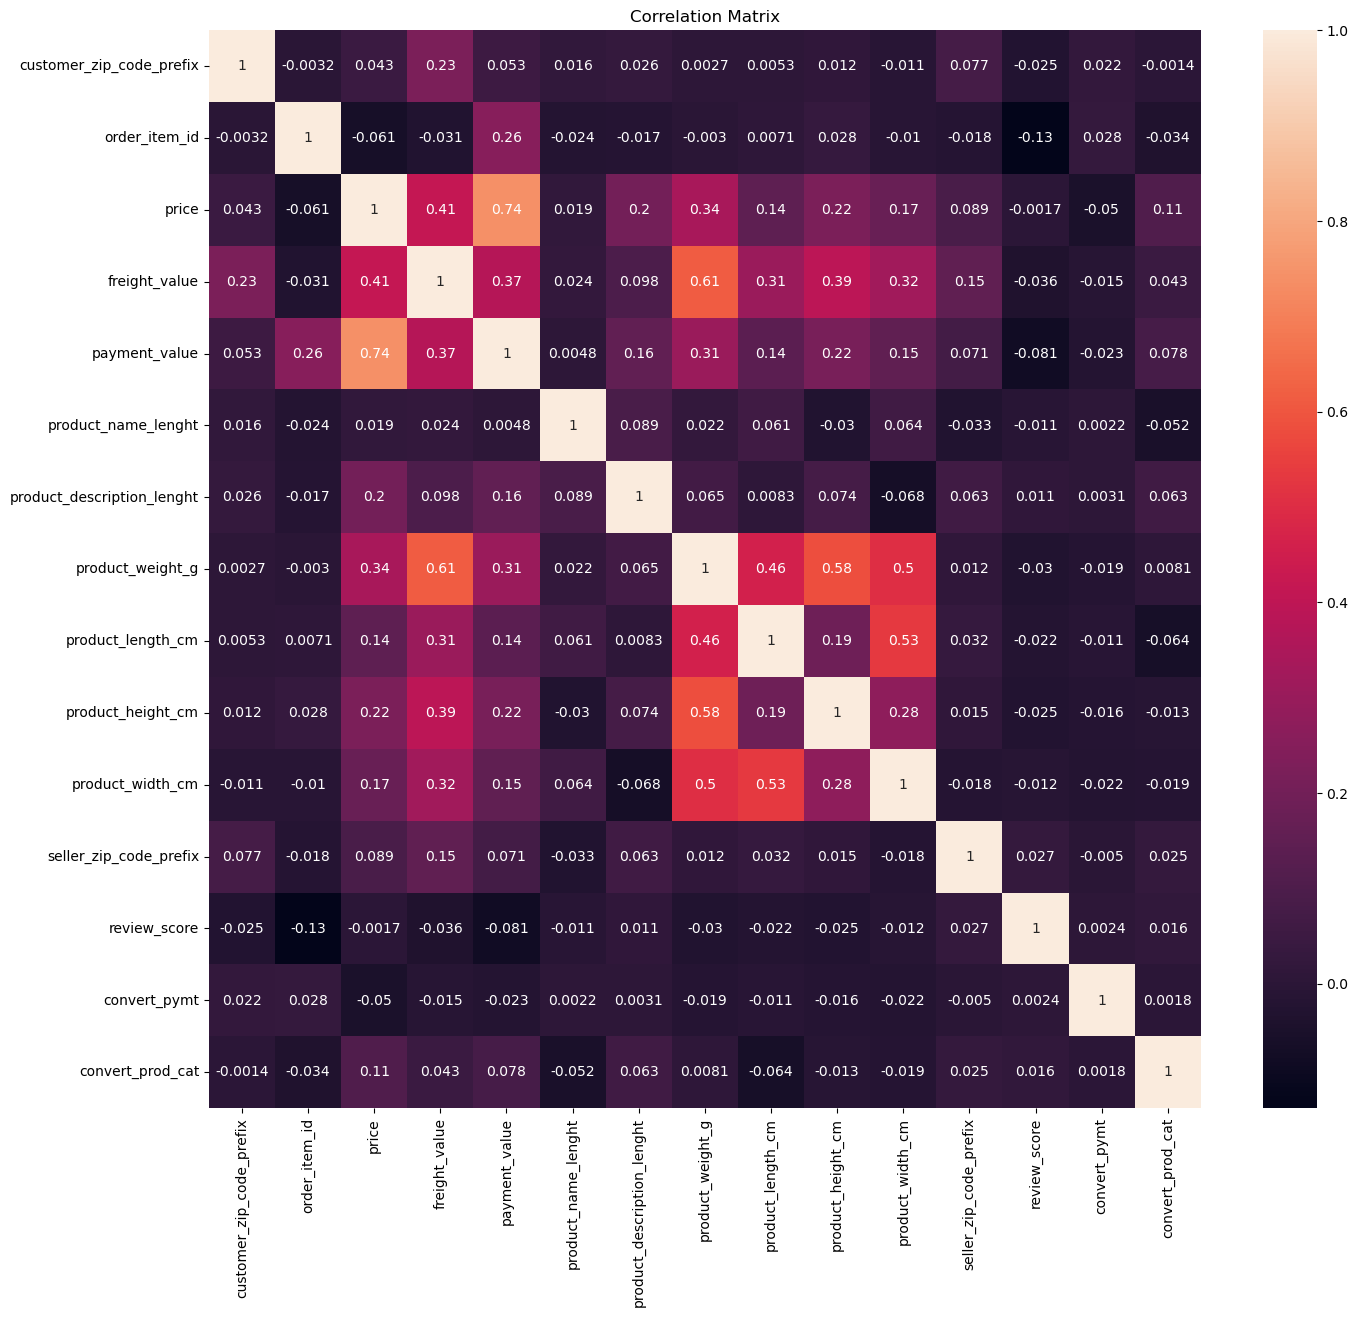

In [27]:
plt.figure(figsize=(16,14))
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Matrix')
plt.savefig('corr_matrix.png')
plt.show()

In [20]:
eigenvalues = np.linalg.eigvals(corr_matrix)
cols = corr_matrix.columns

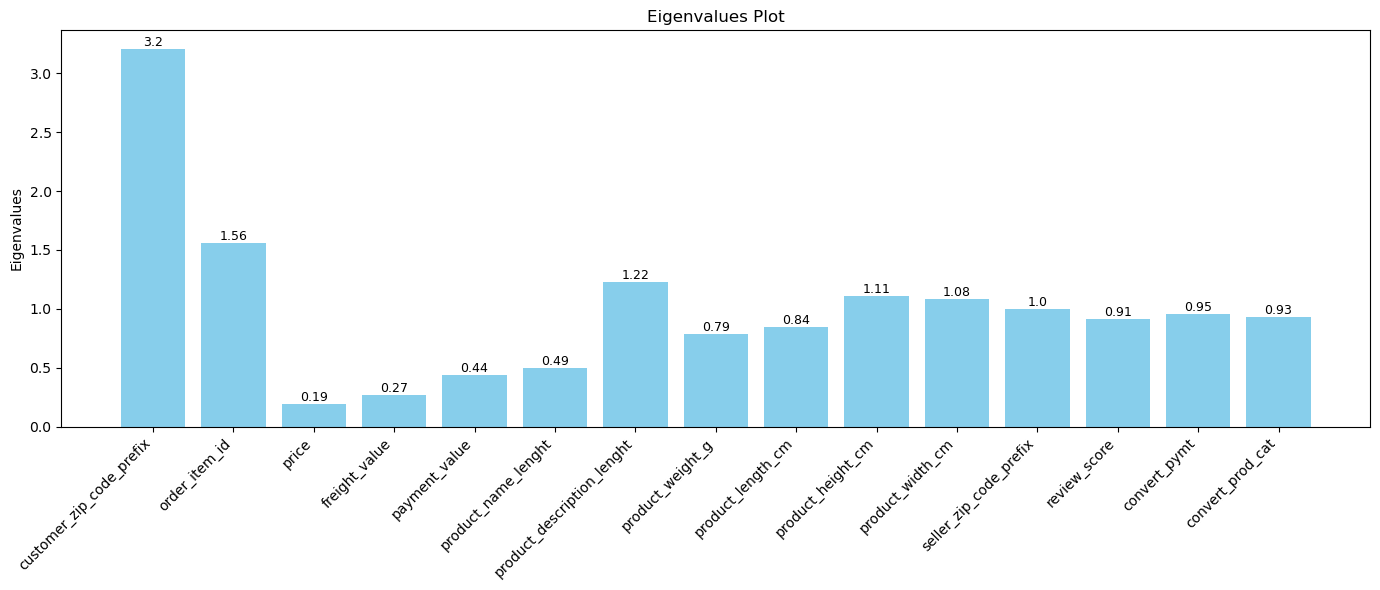

In [21]:
plt.figure(figsize=(14, 6))
bars = plt.bar(cols, list(eigenvalues), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Eigenvalues')
plt.title('Eigenvalues Plot')
plt.tight_layout()

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval,
             round(yval, 2),
             ha='center', va='bottom',
             fontsize=9, color='black')

plt.show()

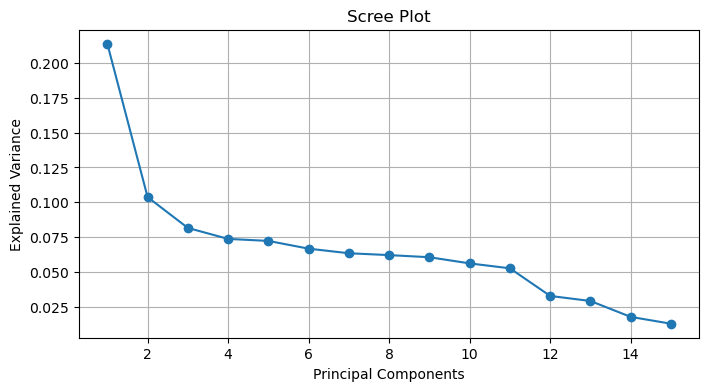

In [22]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(X)

pca = PCA(n_components=15)
pca.fit(df_scaled)

explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.ylabel('Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

In [3]:
df = df.drop(['price',
              'freight_value',
              'payment_value',
              'product_name_lenght',
              'product_weight_g',
              'product_length_cm',
              'product_width_cm',
              'seller_zip_code_prefix',
              'review_score',
              'convert_pymt',
              'convert_prod_cat'], axis=1)
df

,customer_zip_code_prefix,order_item_id,product_description_lenght,product_height_cm,convert_status
0,3149,1.0,268.0,8.0,1
1,3149,1.0,268.0,8.0,1
2,3149,1.0,268.0,8.0,1
3,47813,1.0,178.0,13.0,1
4,75265,1.0,232.0,19.0,1
...,...,...,...,...,...
119138,11722,1.0,828.0,10.0,1
119139,45920,1.0,500.0,90.0,1
119140,28685,1.0,1893.0,20.0,1
119141,28685,2.0,1893.0,20.0,1


In [24]:
Counter(df['convert_status'])

Counter({1: 113209, 0: 1674})

In [4]:
X = df.drop('convert_status',axis=1)
y = df['convert_status']

In [5]:
model_resampling = Pipeline([
    ('oversample', SMOTE(sampling_strategy=0.5)),
    ('undersample', RandomUnderSampler(sampling_strategy=0.8))
])

X_resampled, y_resampled = model_resampling.fit_resample(X, y)

print(pd.Series(y_resampled).value_counts())

1    70755
0    56604
Name: convert_status, dtype: int64


In [27]:
X_resampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127359 entries, 49 to 89348
Data columns (total 4 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   customer_zip_code_prefix    127359 non-null  int64  
 1   order_item_id               127359 non-null  float64
 2   product_description_lenght  127359 non-null  float64
 3   product_height_cm           127359 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 4.9 MB


In [28]:
y_resampled.info()

<class 'pandas.core.series.Series'>
Int64Index: 127359 entries, 49 to 89348
Series name: convert_status
Non-Null Count   Dtype
--------------   -----
127359 non-null  int64
dtypes: int64(1)
memory usage: 1.9 MB


In [6]:
X = X_resampled
y = y_resampled

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [38]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rfc = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None,

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  35.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  34.8s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  33.8s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  34.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=  16.9s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=  17.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=  16.7s
[CV] END max_depth=None, max

/Users/kna00/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
435 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/kna00/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/kna00/anaconda3/lib/python3.10/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Users/kna00/anaconda3/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/Us

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.9597204773869347
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95     11396
           1       0.96      0.97      0.96     14076

    accuracy                           0.96     25472
   macro avg       0.96      0.96      0.96     25472
weighted avg       0.96      0.96      0.96     25472



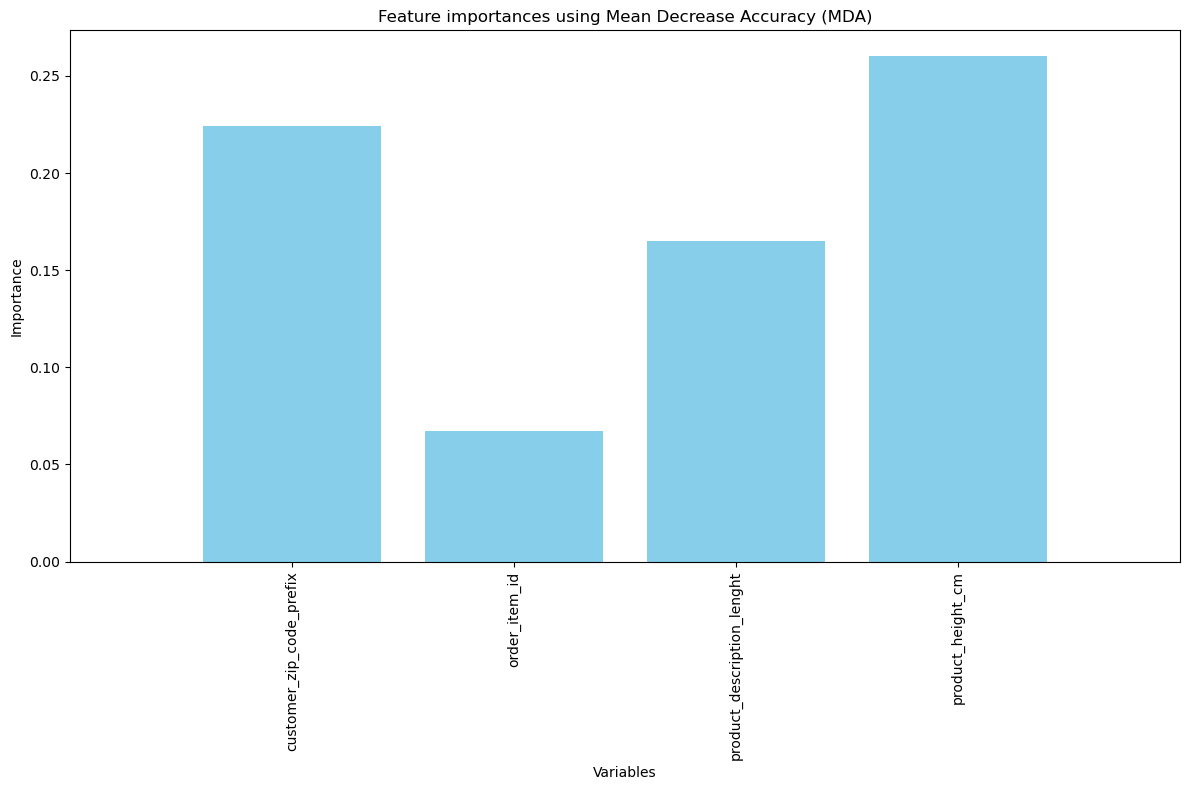

In [41]:
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

feature_importance = result.importances_mean

features = [i for i in X.columns]

plt.figure(figsize=(12, 8))
plt.title("Feature importances using Mean Decrease Accuracy (MDA)")
plt.bar(range(X_test.shape[1]), feature_importance, align="center", color='skyblue')
plt.xticks(range(X_test.shape[1]), np.array(features), rotation=45)
plt.xlim([-1, X_test.shape[1]])
plt.xlabel('Variables')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

In [49]:
l2_regularizer = tf.keras.regularizers.L2(l2=0.001)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def create_model(init_mode='he_uniform'):
    model = Sequential([
        Dense(units=128,
              kernel_initializer=init_mode,
              input_dim=X_train.shape[1],
              kernel_regularizer=l2_regularizer,
              bias_regularizer=l2_regularizer,
              activation='relu'),
        Dense(units=64,
              kernel_initializer=init_mode,
              kernel_regularizer=l2_regularizer,
              bias_regularizer=l2_regularizer,
              activation='relu'),
        Dense(units=1,
              kernel_initializer=init_mode,
              kernel_regularizer=l2_regularizer,
              bias_regularizer=l2_regularizer,
              activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, verbose=0)

param_grid = {
    'batch_size': [10, 20, 40, 60, 80, 100],
    'epochs': [10, 20, 50, 70, 100],
    'model__init_mode': ['he_uniform', 'he_normal']
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: ", grid_search.best_score_)
print("Test set accuracy: ", grid_search.score(X_test_scaled, y_test))

Fitting 3 folds for each of 60 candidates, totalling 180 fits


/Users/kna00/anaconda3/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kna00/anaconda3/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kna00/anaconda3/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kna00/anaconda3/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


/Users/kna00/anaconda3/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kna00/anaconda3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/kna00/anaconda3/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kna00/anaconda3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a la

/Users/kna00/anaconda3/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kna00/anaconda3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/kna00/anaconda3/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kna00/anaconda3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a la

/Users/kna00/anaconda3/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kna00/anaconda3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/kna00/anaconda3/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kna00/anaconda3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a la

/Users/kna00/anaconda3/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kna00/anaconda3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/kna00/anaconda3/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kna00/anaconda3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a la

/Users/kna00/anaconda3/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kna00/anaconda3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/kna00/anaconda3/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kna00/anaconda3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a la

/Users/kna00/anaconda3/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kna00/anaconda3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/kna00/anaconda3/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kna00/anaconda3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a la

/Users/kna00/anaconda3/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kna00/anaconda3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/kna00/anaconda3/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kna00/anaconda3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a la

/Users/kna00/anaconda3/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kna00/anaconda3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/kna00/anaconda3/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kna00/anaconda3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a la

/Users/kna00/anaconda3/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kna00/anaconda3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/kna00/anaconda3/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kna00/anaconda3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a la

/Users/kna00/anaconda3/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kna00/anaconda3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/kna00/anaconda3/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kna00/anaconda3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a la

/Users/kna00/anaconda3/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kna00/anaconda3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/kna00/anaconda3/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kna00/anaconda3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a la

/Users/kna00/anaconda3/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kna00/anaconda3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/kna00/anaconda3/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kna00/anaconda3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a la

Best parameters found:  {'batch_size': 100, 'epochs': 50, 'model__init_mode': 'he_uniform'}
Best cross-validation accuracy:  0.6338296107349551
Test set accuracy:  0.6354820979899497
[CV] END batch_size=10, epochs=10, model__init_mode=he_uniform; total time= 2.5min
[CV] END batch_size=10, epochs=20, model__init_mode=he_uniform; total time= 4.5min
[CV] END batch_size=10, epochs=50, model__init_mode=he_normal; total time=10.8min
[CV] END batch_size=10, epochs=100, model__init_mode=he_uniform; total time=22.0min
[CV] END batch_size=20, epochs=50, model__init_mode=he_uniform; total time= 5.9min
[CV] END batch_size=20, epochs=70, model__init_mode=he_uniform; total time= 7.8min
[CV] END batch_size=20, epochs=100, model__init_mode=he_uniform; total time=11.3min
[CV] END batch_size=40, epochs=50, model__init_mode=he_normal; total time= 2.9min
[CV] END batch_size=40, epochs=100, model__init_mode=he_uniform; total time= 6.0min
[CV] END batch_size=60, epochs=20, model__init_mode=he_normal; total 

[CV] END batch_size=10, epochs=10, model__init_mode=he_normal; total time= 2.6min
[CV] END batch_size=10, epochs=50, model__init_mode=he_uniform; total time=11.0min
[CV] END batch_size=10, epochs=70, model__init_mode=he_normal; total time=15.7min
[CV] END batch_size=10, epochs=100, model__init_mode=he_normal; total time=22.3min
[CV] END batch_size=20, epochs=100, model__init_mode=he_uniform; total time=11.5min
[CV] END batch_size=40, epochs=50, model__init_mode=he_uniform; total time= 3.0min
[CV] END batch_size=40, epochs=70, model__init_mode=he_uniform; total time= 4.2min
[CV] END batch_size=40, epochs=100, model__init_mode=he_normal; total time= 6.1min
[CV] END batch_size=60, epochs=50, model__init_mode=he_normal; total time= 2.2min
[CV] END batch_size=60, epochs=100, model__init_mode=he_uniform; total time= 4.0min
[CV] END batch_size=80, epochs=50, model__init_mode=he_uniform; total time=  46.6s
[CV] END batch_size=80, epochs=70, model__init_mode=he_normal; total time= 1.5min
[CV] E